$$- \Delta u(x) = f(x) \hspace{0.2cm} \text{on} \hspace{0.2cm} D(\omega_2)$$

In [1]:
from helpers import *

In [2]:
MESH_RESOLUTION_RANDOM_FIELD_CALCULATION = 4

[ 0.10382045 -0.63262869]
Vertex Coordinates of the Cell: [[ 0.21345986 -0.46020462]
 [-0.08599808 -0.70825793]
 [ 0.18399958 -0.72942351]]


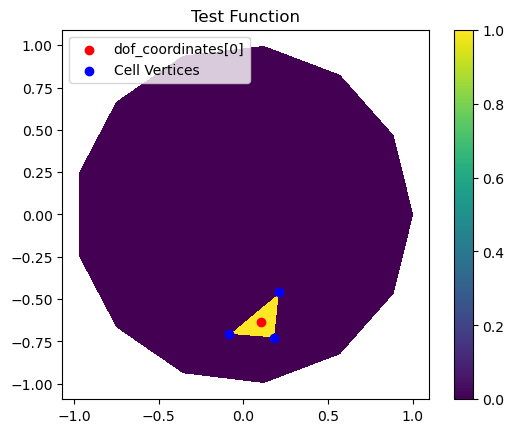

In [3]:
# Understand constant basis functions
mesh = mshr.generate_mesh(DOMAIN, MESH_RESOLUTION_RANDOM_FIELD_CALCULATION)
V = fe.FunctionSpace(mesh, "DG", 0)
test_function = fe.Function(V)
test_function.vector()[0] = 1
c = fe.plot(test_function, title='Test Function')
plt.colorbar(c)

dof_coordinates = V.tabulate_dof_coordinates().reshape((-1, 2))
print(dof_coordinates[0])
plt.scatter(dof_coordinates[0][0], dof_coordinates[0][1], color='red', label='dof_coordinates[0]')

# Identify the cell containing the DOF
dof_index = 0
cell_index = V.dofmap().cell_dofs(dof_index)[0]
cell = fe.Cell(mesh, cell_index)

# Extract the vertex coordinates of the cell
vertex_indices = cell.entities(0)
vertex_coords = np.array([mesh.coordinates()[vertex] for vertex in vertex_indices])
print("Vertex Coordinates of the Cell:", vertex_coords)

# Plot the vertices of the cell
plt.scatter(vertex_coords[:, 0], vertex_coords[:, 1], color='blue', label='Cell Vertices')

plt.legend()
plt.show()

In [4]:
randomFieldV, jacobianV = calculate_vector_field_eigenpairs(MESH_RESOLUTION_RANDOM_FIELD_CALCULATION)
# for MESH_RESOLUTION_RANDOM_FIELD_CALCULATION = 8 it takes approx. 3 minutes
# for MESH_RESOLUTION_RANDOM_FIELD_CALCULATION = 6 it takes approx. 47 seconds

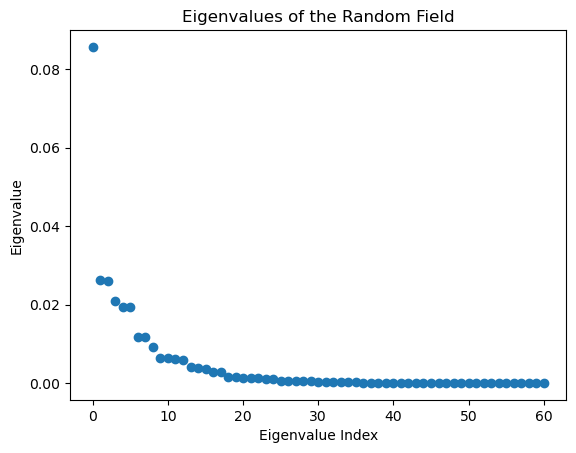

In [16]:
# Plot the eigenvalues
plt.figure()
plt.title('Eigenvalues of the Random Field')
plt.plot(randomFieldV.eigenvalues, 'o')
plt.xlabel('Eigenvalue Index')
plt.ylabel('Eigenvalue')
plt.show()

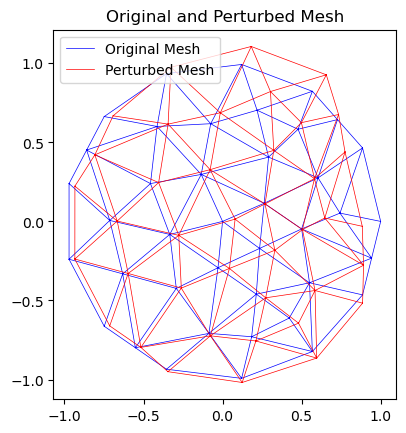

In [5]:
xi = np.random.uniform(-np.sqrt(3), np.sqrt(3), randomFieldV.J)
mesh = mshr.generate_mesh(DOMAIN, MESH_RESOLUTION_RANDOM_FIELD_CALCULATION)
# perturbed mesh based on the "original" mesh used for the KL-expansion
perturbed_coordinates = mesh.coordinates().copy()
for index, coordinate in enumerate(mesh.coordinates()):
    perturbed_coordinates[index] = randomFieldV(coordinate, xi)
# Create a new mesh with the perturbed coordinates
perturbed_mesh = fe.Mesh(mesh)
perturbed_mesh.coordinates()[:] = perturbed_coordinates

# Plot the original mesh and the perturbed mesh in one figure with different colors
plt.figure()
fe.plot(mesh, color='blue', linewidth=0.5, label='Original Mesh')
fe.plot(perturbed_mesh, color='red', linewidth=0.5, label='Perturbed Mesh')
plt.legend()
plt.title(f"Original and Perturbed Mesh")
plt.show()

Solving linear variational problem.
  Building point search tree to accelerate distance queries.
  Computed bounding box tree with 121 nodes for 61 points.
Time taken for solving the Poisson problem: 0.8730490207672119 seconds


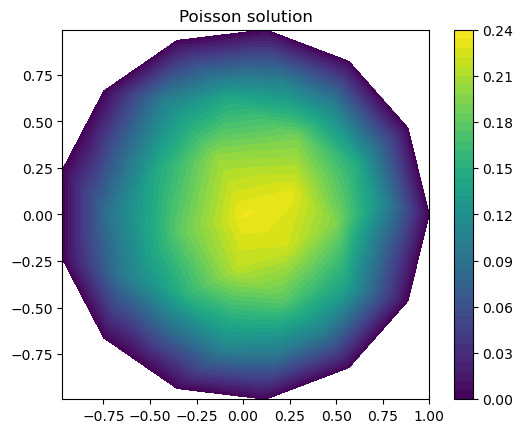

In [6]:
import time

len_xi = randomFieldV.J
xi = np.random.uniform(-np.sqrt(3), np.sqrt(3), len_xi)

if len_xi > randomFieldV.J:
    raise ValueError("len(xi) must be less than randomFieldV.J")

mesh_resolution_solution = 4
time_start = time.time()
u_sol = solve_poisson_for_given_sample(mesh_resolution_solution, jacobianV, xi, RHS_F)
time_end = time.time()
print(f"Time taken for solving the Poisson problem: {time_end - time_start} seconds")

c = fe.plot(u_sol, title="Poisson solution")
plt.colorbar(c)
plt.show()

In [7]:
# det_J_expr = detJExpression(jacobianV, xi, degree=2)
# mesh = mshr.generate_mesh(DOMAIN, 5)
# V = fe.FunctionSpace(mesh, "P", 1)
# det_J_func = fe.project(det_J_expr, V)

# c = fe.plot(det_J_func, title="Determinant of the Jacobian")
# plt.colorbar(c)
# plt.show()

orig_tri_coords:[[-0.29253285 -0.42380699]
 [-0.08599808 -0.70825793]
 [-0.02881614 -0.29297357]]


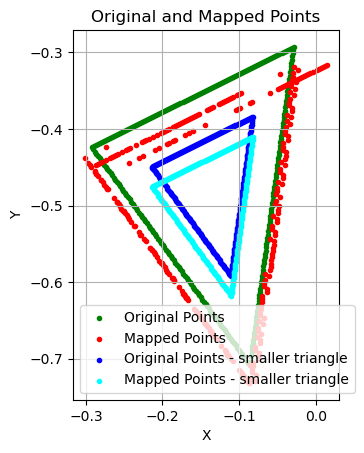

In [8]:
xi = np.random.uniform(-np.sqrt(3), np.sqrt(3), randomFieldV.J)

number_of_points_per_edge = 100

mesh = mshr.generate_mesh(DOMAIN, MESH_RESOLUTION_RANDOM_FIELD_CALCULATION)
orig_tri = next(fe.cells(mesh))
midpoint = orig_tri.midpoint().array()[0:2]
orig_tri_coords = np.array(orig_tri.get_vertex_coordinates()).reshape((-1, 2))
print(f"orig_tri_coords:{orig_tri_coords}")
orig_points = []
orig_points_small = []
for i in range(number_of_points_per_edge):
    orig_points.append(i/number_of_points_per_edge * orig_tri_coords[0] + (1 - i/number_of_points_per_edge) * orig_tri_coords[1])
    orig_points.append(i/number_of_points_per_edge * orig_tri_coords[1] + (1 - i/number_of_points_per_edge) * orig_tri_coords[2])
    orig_points.append(i/number_of_points_per_edge * orig_tri_coords[2] + (1 - i/number_of_points_per_edge) * orig_tri_coords[0])
    orig_points_small.append(1/2 *(i/number_of_points_per_edge * orig_tri_coords[0] + (1 - i/number_of_points_per_edge) * orig_tri_coords[1]) + 1/2 * midpoint)
    orig_points_small.append(1/2 * (i/number_of_points_per_edge * orig_tri_coords[1] + (1 - i/number_of_points_per_edge) * orig_tri_coords[2]) + 1/2 * midpoint)
    orig_points_small.append(1/2 * (i/number_of_points_per_edge * orig_tri_coords[2] + (1 - i/number_of_points_per_edge) * orig_tri_coords[0]) + 1/2 * midpoint)

mapped_points = []
for orig_point in orig_points:
    mapped_points.append(randomFieldV(orig_point, xi))
mapped_points_small = []
for orig_point_small in orig_points_small:
    mapped_points_small.append(randomFieldV(orig_point_small, xi))

orig_points = np.array(orig_points)
mapped_points = np.array(mapped_points)
orig_points_small = np.array(orig_points_small)
mapped_points_small = np.array(mapped_points_small)

plt.figure()

plt.scatter(orig_points[:, 0], orig_points[:, 1], color='green', label='Original Points', marker='.')
plt.scatter(mapped_points[:, 0], mapped_points[:, 1], color='red', label='Mapped Points', marker='.')

plt.scatter(orig_points_small[:, 0], orig_points_small[:, 1], color='blue', label='Original Points - smaller triangle', marker='.')
plt.scatter(mapped_points_small[:, 0], mapped_points_small[:, 1], color='cyan', label='Mapped Points - smaller triangle', marker='.')

plt.legend()
plt.title('Original and Mapped Points')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(True)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

image_bary_coords: [0.91329621 0.00581081 0.08089298]
image_tria_coords: [[ 0.01505739  0.03628998]
 [-0.32504284 -0.06265971]
 [-0.02303163 -0.28159923]]
original_tria_coords: [[ 0.00000000e+00  1.11022302e-16]
 [-3.33996540e-01 -8.23227534e-02]
 [-2.88161414e-02 -2.92973573e-01]]
New inner point in the original triangle: [-0.00427181 -0.02417787]


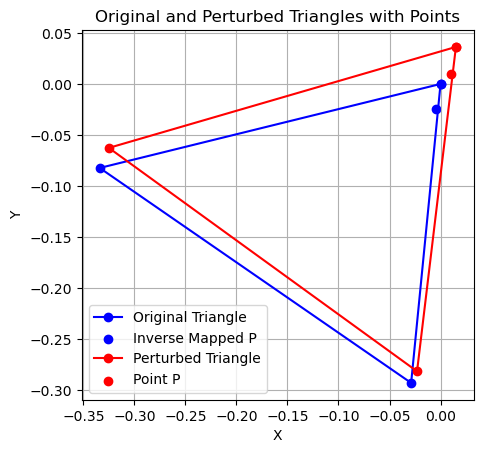

Solving linear variational problem.
inverse_mapped_P_solution: 0.2185969915074803


In [9]:
P = fe.Point(0.01, 0.01)
len_xi = 2

xi = np.random.uniform(-np.sqrt(3), np.sqrt(3), len_xi)

mesh = mshr.generate_mesh(DOMAIN, MESH_RESOLUTION_RANDOM_FIELD_CALCULATION)
# perturbed mesh based on the "original" mesh used for the KL-expansion
perturbed_coordinates = mesh.coordinates().copy()
for index, coordinate in enumerate(mesh.coordinates()):
    perturbed_coordinates[index] = randomFieldV(coordinate, xi)
# Create a new mesh with the perturbed coordinates
perturbed_mesh = fe.Mesh(mesh)
perturbed_mesh.coordinates()[:] = perturbed_coordinates

# Find the cell containing point P
image_tria_coords = None
for cell in fe.cells(perturbed_mesh):
    if cell.contains(P):
        image_tria_coords = np.array(cell.get_vertex_coordinates()).reshape((-1, 2))
        break

if image_tria_coords is None:
    raise ValueError("Point P is not inside any cell of the perturbed mesh")
        
image_bary_coords = barycentric_coords(P, image_tria_coords)

print(f"image_bary_coords: {image_bary_coords}")

perturbed_coords = perturbed_mesh.coordinates()
original_coords = mesh.coordinates()

indices = []
for vertex in image_tria_coords:
    for i, coord in enumerate(perturbed_coords):
        if np.allclose(vertex, coord):
            indices.append(i)
            break

# Get the corresponding coordinates in the original mesh
original_tria_coords = original_coords[indices]
print(f"image_tria_coords: {image_tria_coords}")
print(f"original_tria_coords: {original_tria_coords}")

P_hat = (
    image_bary_coords[0] * original_tria_coords[0] +
    image_bary_coords[1] * original_tria_coords[1] +
    image_bary_coords[2] * original_tria_coords[2]
)
print(f"New inner point in the original triangle: {P_hat}")

# Plot the original triangle and the new_inner_point
plt.figure()

# Plot original triangle
plt.plot(*zip(*original_tria_coords, original_tria_coords[0]), 'bo-', label='Original Triangle')
plt.scatter(*P_hat, color='blue', label='Inverse Mapped P')

# Plot perturbed triangle
plt.plot(*zip(*image_tria_coords, image_tria_coords[0]), 'ro-', label='Perturbed Triangle')
plt.scatter(P.x(), P.y(), color='red', label='Point P')

plt.legend()
plt.title('Original and Perturbed Triangles with Points')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(True)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

# Calculate the solution at the inverse mapped point
mesh_resolution_solution = 3
u_sol = solve_poisson_for_given_sample(mesh_resolution_solution, jacobianV, xi, RHS_F)
inverse_mapped_P_solution = u_sol(P_hat)
print(f"inverse_mapped_P_solution: {inverse_mapped_P_solution}")


R_nv (maximal perturbation distance): 0.9036026371662118
Iteration 1/1
Solving linear variational problem.


/Users/elias/miniconda3/envs/fenics_x64/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/elias/miniconda3/envs/fenics_x64/lib/python3.12/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


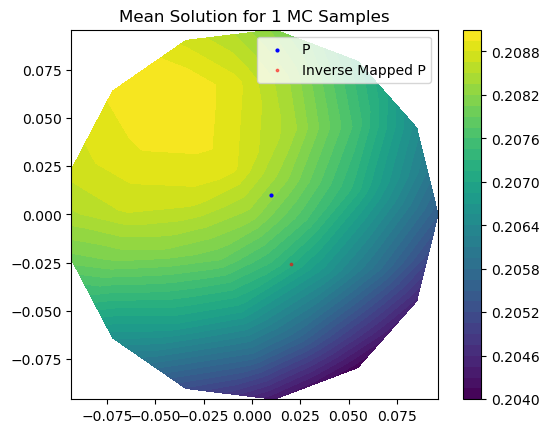

Iteration 1/2
Solving linear variational problem.
Iteration 2/2
Solving linear variational problem.


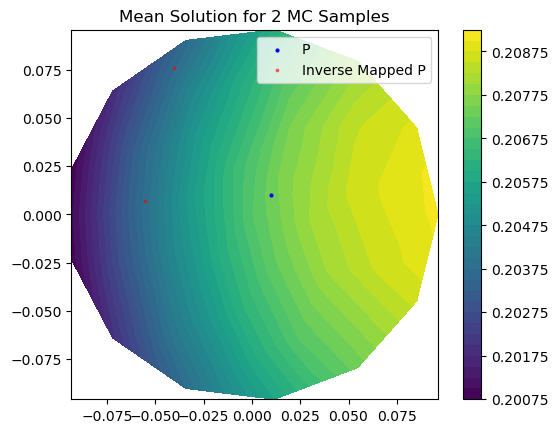

Iteration 1/4
Solving linear variational problem.
Iteration 2/4
Solving linear variational problem.
Iteration 3/4
Solving linear variational problem.
Iteration 4/4
Solving linear variational problem.


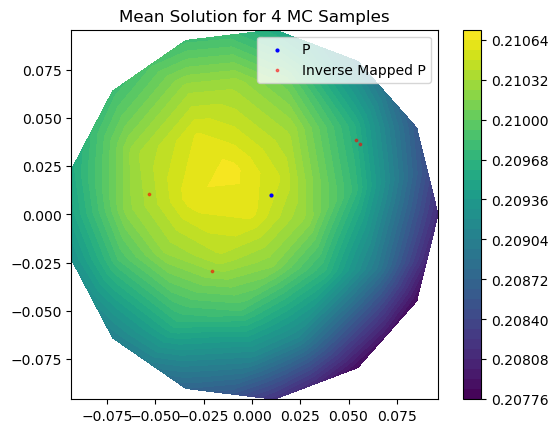

Iteration 1/8
Solving linear variational problem.
Iteration 2/8
Solving linear variational problem.
Iteration 3/8
Solving linear variational problem.
Iteration 4/8
Solving linear variational problem.
Iteration 5/8
Solving linear variational problem.
Iteration 6/8
Solving linear variational problem.
Iteration 7/8
Solving linear variational problem.
Iteration 8/8
Solving linear variational problem.


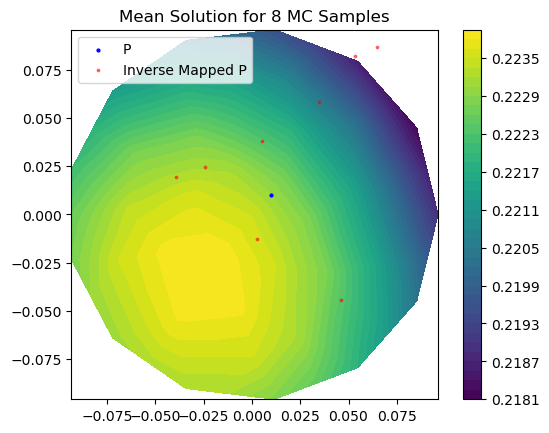

Iteration 1/16
Solving linear variational problem.
Iteration 2/16
Solving linear variational problem.
Iteration 3/16
Solving linear variational problem.
Iteration 4/16
Solving linear variational problem.
Iteration 5/16
Solving linear variational problem.
Iteration 6/16
Solving linear variational problem.
Iteration 7/16
Solving linear variational problem.
Iteration 8/16
Solving linear variational problem.
Iteration 9/16
Solving linear variational problem.
Iteration 10/16
Solving linear variational problem.
Iteration 11/16
Solving linear variational problem.
Iteration 12/16
Solving linear variational problem.
Iteration 13/16
Solving linear variational problem.
Iteration 14/16
Solving linear variational problem.
Iteration 15/16
Solving linear variational problem.
Iteration 16/16
Solving linear variational problem.


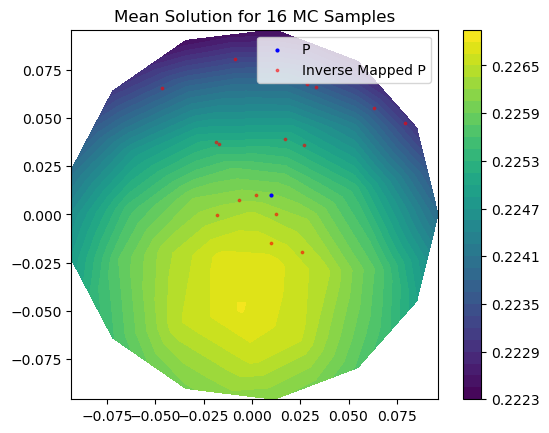

Iteration 1/32
Solving linear variational problem.
Iteration 2/32
Solving linear variational problem.
Iteration 3/32
Solving linear variational problem.
Iteration 4/32
Solving linear variational problem.
Iteration 5/32
Solving linear variational problem.
Iteration 6/32
Solving linear variational problem.
Iteration 7/32
Solving linear variational problem.
Iteration 8/32
Solving linear variational problem.
Iteration 9/32
Solving linear variational problem.
Iteration 10/32
Solving linear variational problem.
Iteration 11/32
Solving linear variational problem.
Iteration 12/32
Solving linear variational problem.
Iteration 13/32
Solving linear variational problem.
Iteration 14/32
Solving linear variational problem.
Iteration 15/32
Solving linear variational problem.
Iteration 16/32
Solving linear variational problem.
Iteration 17/32
Solving linear variational problem.
Iteration 18/32
Solving linear variational problem.
Iteration 19/32
Solving linear variational problem.
Iteration 20/32
Solvi

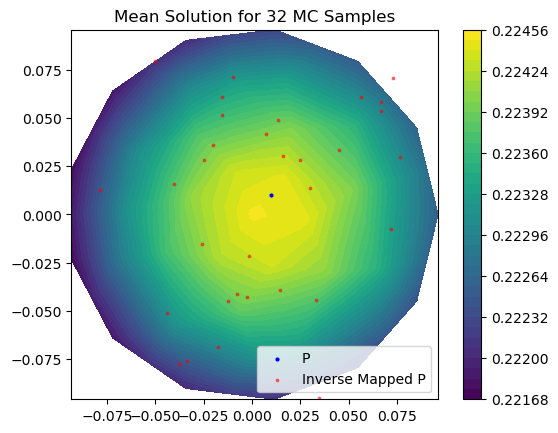

/var/folders/0n/bb4_kwsn3n5c5_7n_mgl2n540000gn/T/ipykernel_6671/2533598789.py:55: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax1.plot(mc_samples_array, means_P, 'bo', marker='x', linestyle='None', label='Means')
/var/folders/0n/bb4_kwsn3n5c5_7n_mgl2n540000gn/T/ipykernel_6671/2533598789.py:63: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "go" (-> marker='o'). The keyword argument will take precedence.
  ax2.plot(mc_samples_array, vars_P, 'go', marker='x', linestyle='None', label='Variance')


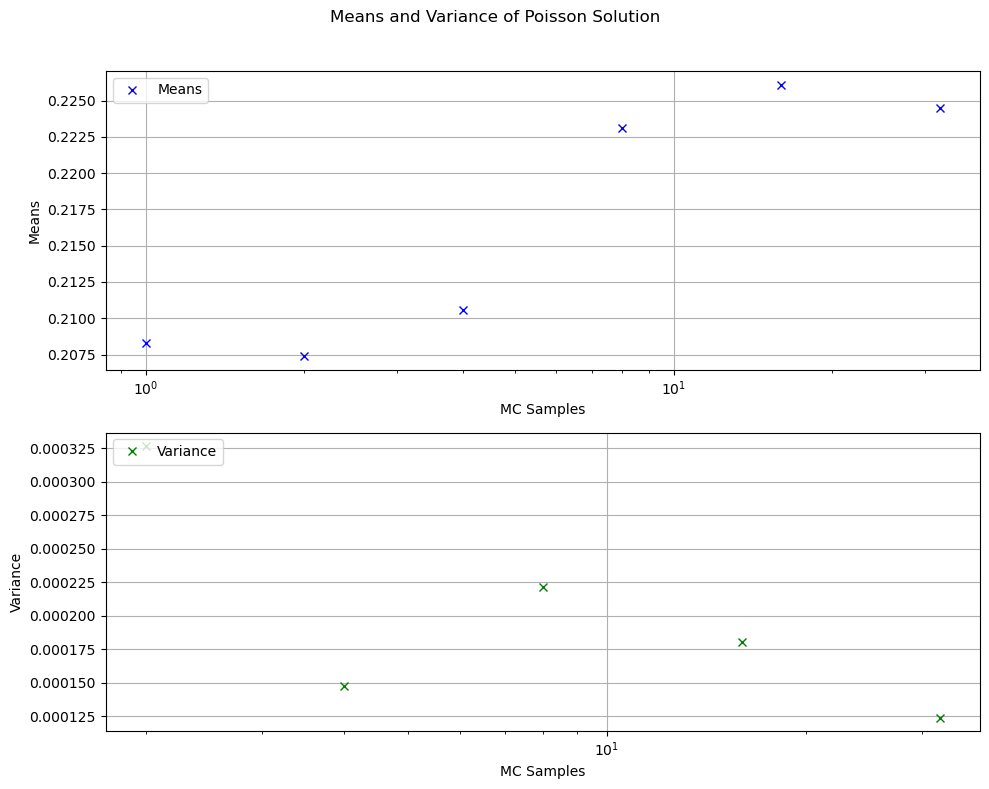

In [12]:
mc_samples_array = [1, 2, 4, 8, 16, 32]

P = fe.Point(0.01, 0.01)
mesh_resolution_inverse_mapping = MESH_RESOLUTION_RANDOM_FIELD_CALCULATION # Actually has to be MESH_RESOLUTION_RANDOM_FIELD_CALCULATION because else we don't have the affine mapping
mesh_resolution_solution = 3
len_xi = randomFieldV.J
mesh_resolution_NVA = 4
show_inverse_mapped_P = True



NVA = non_varying_area(len_xi, randomFieldV)
if not pointInNVA(P, NVA):
    raise ValueError("Point P is not in the non-varying area")
mesh_NVA = mshr.generate_mesh(NVA, mesh_resolution_NVA)
V_NVA = fe.FunctionSpace(mesh_NVA, "CG", 1)
dofmap = V_NVA.dofmap()
dof_coordinates = V_NVA.tabulate_dof_coordinates().reshape((-1, mesh_NVA.geometry().dim()))

means_P = []
vars_P = []

for mc_samples in mc_samples_array:
    mean_sols_P = []
    u_sols = []
    P_hats = []
    mean_sol = fe.Function(V_NVA)
    mean_sol.vector()[:] = 0
    for i in range(mc_samples):
        print(f"Iteration {i+1}/{mc_samples}")
        xi = np.random.uniform(-np.sqrt(3), np.sqrt(3), len_xi)
        u_sols.append(solve_poisson_for_given_sample(mesh_resolution_solution, jacobianV, xi, RHS_F))
        P_hat = inverse_mapping(P, randomFieldV, xi, mesh_resolution_inverse_mapping)
        P_hats.append(P_hat)
        mean_sols_P.append(u_sols[i](P_hat))
        for j, point_coords in enumerate(dof_coordinates):
            point_hat = inverse_mapping(fe.Point(point_coords), randomFieldV, xi, mesh_resolution_inverse_mapping)
            mean_sol.vector()[j] += u_sols[i](point_hat) / mc_samples
    means_P.append(np.mean(mean_sols_P))
    vars_P.append(np.var(mean_sols_P, ddof=1))
    c = fe.plot(mean_sol, title=f"Mean Solution for {mc_samples} MC Samples")
    if show_inverse_mapped_P:
        plt.scatter(P.x(), P.y(), color='blue', label='P', s=4)
        P_hats_x, P_hats_y = zip(*P_hats)
        plt.scatter(P_hats_x, P_hats_y, color='red', label='Inverse Mapped P', alpha = 0.5, s=3)
        plt.legend()
    plt.colorbar(c)
    plt.show()


# Plotting
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Plot means and true solution
ax1.plot(mc_samples_array, means_P, 'bo', marker='x', linestyle='None', label='Means')
ax1.set_xscale('log')
ax1.set_xlabel('MC Samples')
ax1.set_ylabel('Means')
ax1.legend(loc='upper left')
ax1.grid(True)

# Plot variance
ax2.plot(mc_samples_array, vars_P, 'go', marker='x', linestyle='None', label='Variance')
ax2.set_xscale('log')
ax2.set_xlabel('MC Samples')
ax2.set_ylabel('Variance')
ax2.legend(loc='upper left')
ax2.grid(True)

plt.suptitle('Means and Variance of Poisson Solution')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

R_nv (maximal perturbation distance): 0.5650206832100484
R_nv (maximal perturbation distance): 0.9036026371662118
Iteration reference solution 1/20
Solving linear variational problem.
  Building point search tree to accelerate distance queries.
  Computed bounding box tree with 375 nodes for 188 points.
Iteration reference solution 2/20
Solving linear variational problem.
Iteration reference solution 3/20
Solving linear variational problem.
Iteration reference solution 4/20
Solving linear variational problem.
Iteration reference solution 5/20
Solving linear variational problem.
Iteration reference solution 6/20
Solving linear variational problem.
Iteration reference solution 7/20
Solving linear variational problem.
Iteration reference solution 8/20
Solving linear variational problem.
Iteration reference solution 9/20
Solving linear variational problem.
Iteration reference solution 10/20
Solving linear variational problem.
Iteration reference solution 11/20
Solving linear variational pr

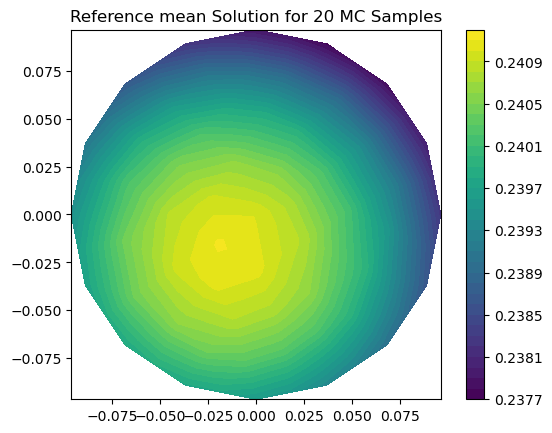

Iteration 1/1
Solving linear variational problem.
  Building point search tree to accelerate distance queries.
  Computed bounding box tree with 121 nodes for 61 points.


/Users/elias/miniconda3/envs/fenics_x64/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/elias/miniconda3/envs/fenics_x64/lib/python3.12/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


*** Warning: Degree of exact solution may be inadequate for accurate result in errornorm.
*** Warning: Degree of exact solution may be inadequate for accurate result in errornorm.


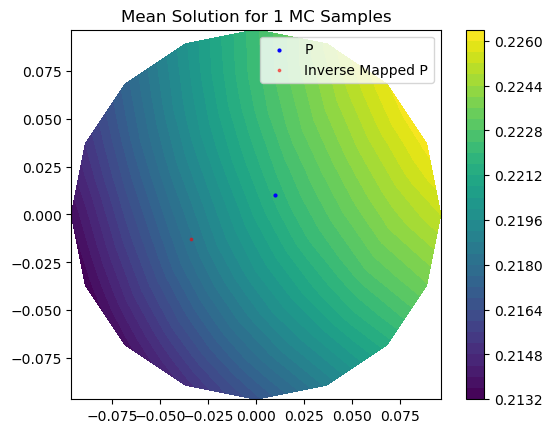

Iteration 1/2
Solving linear variational problem.
Iteration 2/2
Solving linear variational problem.
*** Warning: Degree of exact solution may be inadequate for accurate result in errornorm.
*** Warning: Degree of exact solution may be inadequate for accurate result in errornorm.


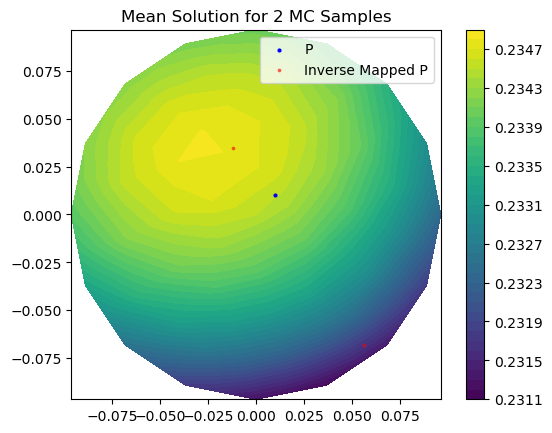

Iteration 1/4
Solving linear variational problem.
Iteration 2/4
Solving linear variational problem.
Iteration 3/4
Solving linear variational problem.
Iteration 4/4
Solving linear variational problem.
*** Warning: Degree of exact solution may be inadequate for accurate result in errornorm.
*** Warning: Degree of exact solution may be inadequate for accurate result in errornorm.


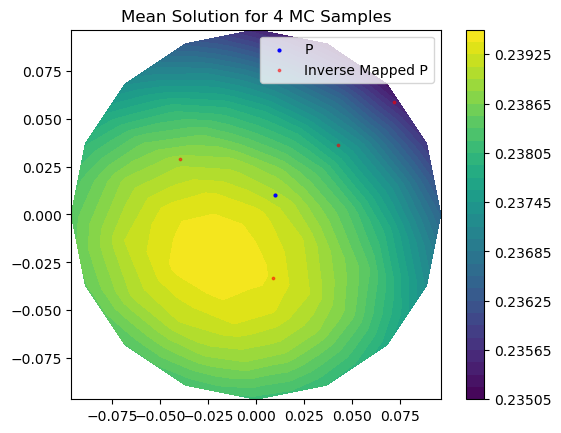

Iteration 1/8
Solving linear variational problem.
Iteration 2/8
Solving linear variational problem.
Iteration 3/8
Solving linear variational problem.
Iteration 4/8
Solving linear variational problem.
Iteration 5/8
Solving linear variational problem.
Iteration 6/8
Solving linear variational problem.
Iteration 7/8
Solving linear variational problem.
Iteration 8/8
Solving linear variational problem.
*** Warning: Degree of exact solution may be inadequate for accurate result in errornorm.
*** Warning: Degree of exact solution may be inadequate for accurate result in errornorm.


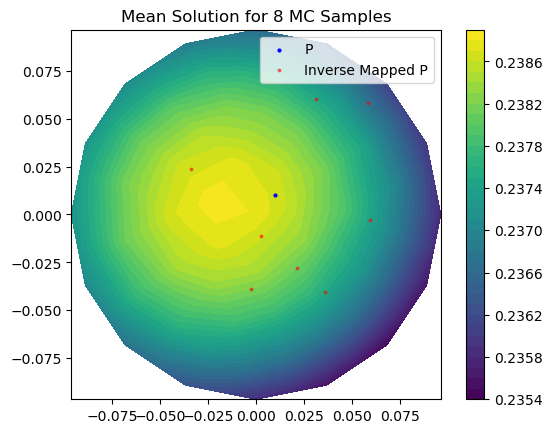

Iteration 1/16
Solving linear variational problem.
Iteration 2/16
Solving linear variational problem.
Iteration 3/16
Solving linear variational problem.
Iteration 4/16
Solving linear variational problem.
Iteration 5/16
Solving linear variational problem.
Iteration 6/16
Solving linear variational problem.
Iteration 7/16
Solving linear variational problem.
Iteration 8/16
Solving linear variational problem.
Iteration 9/16
Solving linear variational problem.
Iteration 10/16
Solving linear variational problem.
Iteration 11/16
Solving linear variational problem.
Iteration 12/16
Solving linear variational problem.
Iteration 13/16
Solving linear variational problem.
Iteration 14/16
Solving linear variational problem.
Iteration 15/16
Solving linear variational problem.
Iteration 16/16
Solving linear variational problem.
*** Warning: Degree of exact solution may be inadequate for accurate result in errornorm.
*** Warning: Degree of exact solution may be inadequate for accurate result in errornor

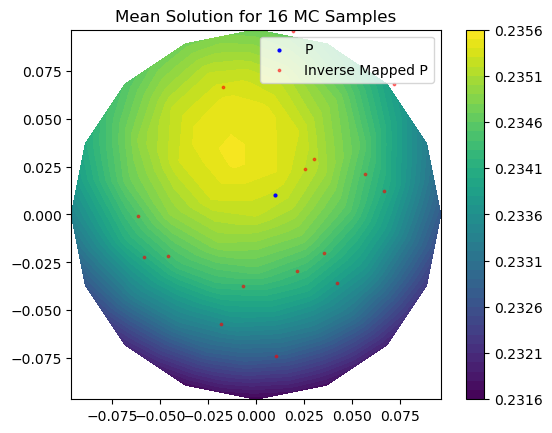

Iteration 1/32
Solving linear variational problem.
Iteration 2/32
Solving linear variational problem.
Iteration 3/32
Solving linear variational problem.
Iteration 4/32
Solving linear variational problem.
Iteration 5/32
Solving linear variational problem.
Iteration 6/32
Solving linear variational problem.
Iteration 7/32
Solving linear variational problem.
Iteration 8/32
Solving linear variational problem.
Iteration 9/32
Solving linear variational problem.
Iteration 10/32
Solving linear variational problem.
Iteration 11/32
Solving linear variational problem.
Iteration 12/32
Solving linear variational problem.
Iteration 13/32
Solving linear variational problem.
Iteration 14/32
Solving linear variational problem.
Iteration 15/32
Solving linear variational problem.
Iteration 16/32
Solving linear variational problem.
Iteration 17/32
Solving linear variational problem.
Iteration 18/32
Solving linear variational problem.
Iteration 19/32
Solving linear variational problem.
Iteration 20/32
Solvi

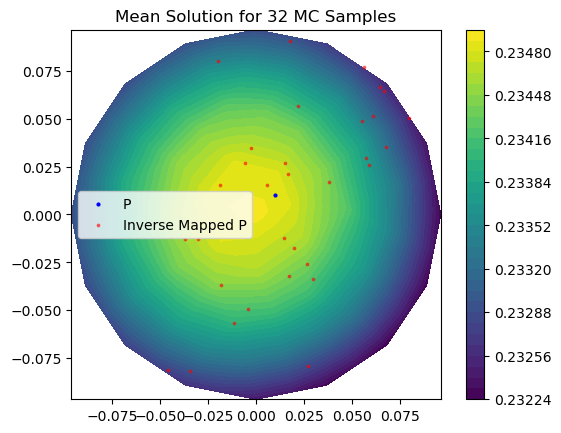

/var/folders/0n/bb4_kwsn3n5c5_7n_mgl2n540000gn/T/ipykernel_6671/729726071.py:96: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax1.plot(mc_samples_array, means_P, 'bo', marker='x', linestyle='None', label='Means')
/var/folders/0n/bb4_kwsn3n5c5_7n_mgl2n540000gn/T/ipykernel_6671/729726071.py:105: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "go" (-> marker='o'). The keyword argument will take precedence.
  ax2.plot(mc_samples_array, vars_P, 'go', marker='x', linestyle='None', label='Variance')


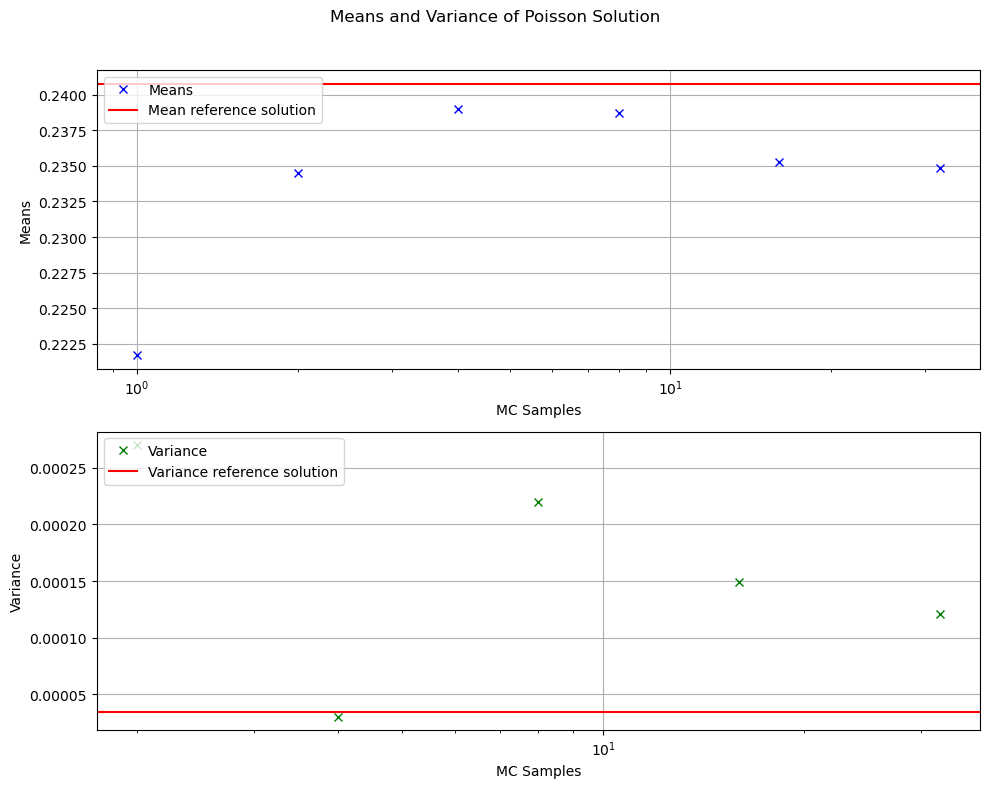

/var/folders/0n/bb4_kwsn3n5c5_7n_mgl2n540000gn/T/ipykernel_6671/729726071.py:121: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "bo-" (-> linestyle='-'). The keyword argument will take precedence.
  ax1.plot(mc_samples_array, L2_errors, 'bo-', marker='x', linestyle='None', label='L2 Error')
/var/folders/0n/bb4_kwsn3n5c5_7n_mgl2n540000gn/T/ipykernel_6671/729726071.py:121: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo-" (-> marker='o'). The keyword argument will take precedence.
  ax1.plot(mc_samples_array, L2_errors, 'bo-', marker='x', linestyle='None', label='L2 Error')
/var/folders/0n/bb4_kwsn3n5c5_7n_mgl2n540000gn/T/ipykernel_6671/729726071.py:128: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "bo-" (-> linestyle='-'). The keyword argument will take precedence.
  ax2.plot(mc_samples_array, H1_errors, 'bo-', marker='x', line

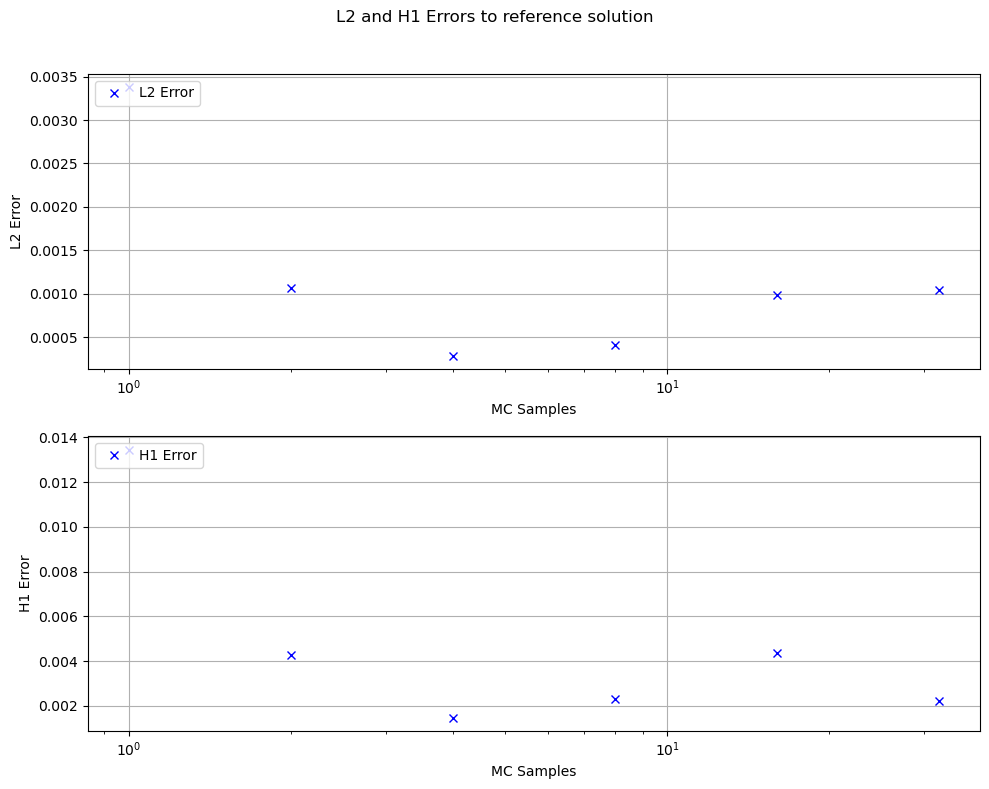

In [14]:
# Calculate one really fine solution for mean and variance and then compare with MC-approximations in L2-norm and H1-norm


ref_mesh_resolution = 7
ref_randomFieldV, ref_jacobianV = calculate_vector_field_eigenpairs(ref_mesh_resolution)

mesh_resolution = 4
randomFieldV, jacobianV = calculate_vector_field_eigenpairs(mesh_resolution)

len_xi = np.min([randomFieldV.J, ref_randomFieldV.J])
P = fe.Point(0.01, 0.01)
mesh_resolution_NVA = 5

# Calculate NVA for both random fields
NVA_ref = non_varying_area(len_xi, ref_randomFieldV)
NVA = non_varying_area(len_xi, randomFieldV)
if not pointInNVA(P, NVA) or not pointInNVA(P, NVA_ref):
    raise ValueError("Point P is not in the non-varying area")
if NVA_ref.radius() < NVA.radius():
    mesh_NVA = mshr.generate_mesh(NVA_ref, mesh_resolution_NVA)
else:
    mesh_NVA = mshr.generate_mesh(NVA, mesh_resolution_NVA)
V_NVA = fe.FunctionSpace(mesh_NVA, "CG", 1)
dofmap = V_NVA.dofmap()
dof_coordinates = V_NVA.tabulate_dof_coordinates().reshape((-1, mesh_NVA.geometry().dim()))

# Calculate the reference solution
ref_mc_samples = 20
ref_mesh_resolution_solution = 6
ref_mesh_resolution_inverse_mapping = ref_mesh_resolution
ref_mean_sol = fe.Function(V_NVA)
ref_mean_sol.vector()[:] = 0
ref_u_sols = []
ref_mean_sols_P = []
for i in range(ref_mc_samples):
    print(f"Iteration reference solution {i+1}/{ref_mc_samples}")
    xi = np.random.uniform(-np.sqrt(3), np.sqrt(3), len_xi)
    ref_u_sols.append(solve_poisson_for_given_sample(ref_mesh_resolution_solution, ref_jacobianV, xi, RHS_F))
    P_hat = inverse_mapping(P, ref_randomFieldV, xi, ref_mesh_resolution_inverse_mapping)
    ref_mean_sols_P.append(ref_u_sols[i](P_hat))
    for j, point_coords in enumerate(dof_coordinates):
        point_hat = inverse_mapping(fe.Point(point_coords), ref_randomFieldV, xi, ref_mesh_resolution_inverse_mapping)
        ref_mean_sol.vector()[j] += ref_u_sols[i](point_hat) / ref_mc_samples
c = fe.plot(ref_mean_sol, title=f"Reference mean Solution for {ref_mc_samples} MC Samples")
plt.colorbar(c)
plt.show()


mc_samples_array = [1, 2, 4, 8, 16, 32]
mesh_resolution_solution = 4
mesh_resolution_inverse_mapping = mesh_resolution


show_inverse_mapped_P = True

means_P = []
vars_P = []

L2_errors = []
H1_errors = []

for mc_samples in mc_samples_array:
    mean_sols_P = []
    u_sols = []
    P_hats = []
    mean_sol = fe.Function(V_NVA)
    mean_sol.vector()[:] = 0
    for i in range(mc_samples):
        print(f"Iteration {i+1}/{mc_samples}")
        xi = np.random.uniform(-np.sqrt(3), np.sqrt(3), len_xi)
        u_sols.append(solve_poisson_for_given_sample(mesh_resolution_solution, jacobianV, xi, RHS_F))
        P_hat = inverse_mapping(P, randomFieldV, xi, mesh_resolution_inverse_mapping)
        P_hats.append(P_hat)
        mean_sols_P.append(u_sols[i](P_hat))
        for j, point_coords in enumerate(dof_coordinates):
            point_hat = inverse_mapping(fe.Point(point_coords), randomFieldV, xi, mesh_resolution_inverse_mapping)
            mean_sol.vector()[j] += u_sols[i](point_hat) / mc_samples
    means_P.append(np.mean(mean_sols_P))
    vars_P.append(np.var(mean_sols_P, ddof=1))
    L2_errors.append(fe.errornorm(ref_mean_sol, mean_sol, 'L2'))
    H1_errors.append(fe.errornorm(ref_mean_sol, mean_sol, 'H1'))
    c = fe.plot(mean_sol, title=f"Mean Solution for {mc_samples} MC Samples")
    if show_inverse_mapped_P:
        plt.scatter(P.x(), P.y(), color='blue', label='P', s=4)
        P_hats_x, P_hats_y = zip(*P_hats)
        plt.scatter(P_hats_x, P_hats_y, color='red', label='Inverse Mapped P', alpha = 0.5, s=3)
        plt.legend()
    plt.colorbar(c)
    plt.show()


# Plotting
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Plot means and true solution
ax1.plot(mc_samples_array, means_P, 'bo', marker='x', linestyle='None', label='Means')
ax1.axhline(y=np.mean(ref_mean_sols_P), color='r', linestyle='-', label='Mean reference solution')
ax1.set_xscale('log')
ax1.set_xlabel('MC Samples')
ax1.set_ylabel('Means')
ax1.legend(loc='upper left')
ax1.grid(True)

# Plot variance
ax2.plot(mc_samples_array, vars_P, 'go', marker='x', linestyle='None', label='Variance')
ax2.axhline(y=np.var(ref_mean_sols_P), color='r', linestyle='-', label='Variance reference solution')
ax2.set_xscale('log')
ax2.set_xlabel('MC Samples')
ax2.set_ylabel('Variance')
ax2.legend(loc='upper left')
ax2.grid(True)

plt.suptitle('Means and Variance of Poisson Solution')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


# Calculate L2 and H1 errors
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

ax1.plot(mc_samples_array, L2_errors, 'bo-', marker='x', linestyle='None', label='L2 Error')
ax1.set_xscale('log')
ax1.set_xlabel('MC Samples')
ax1.set_ylabel('L2 Error')
ax1.legend(loc='upper left')
ax1.grid(True)

ax2.plot(mc_samples_array, H1_errors, 'bo-', marker='x', linestyle='None', label='H1 Error')
ax2.set_xscale('log')
ax2.set_xlabel('MC Samples')
ax2.set_ylabel('H1 Error')
ax2.legend(loc='upper left')
ax2.grid(True)

plt.suptitle('L2 and H1 Errors to reference solution')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()